In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import cv2
import random
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
from torchsummary import summary

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/archive (7).zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [4]:
folder_path = "/content/landscape Images/color"

files = os.listdir(folder_path)

image_files = [f for f in files if f.endswith(('jpg'))]

color_images = []

for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    image = Image.open(image_path)
    color_images.append(image)

In [5]:
folder_path = "/content/landscape Images/gray"

files = os.listdir(folder_path)

image_files = [f for f in files if f.endswith(('jpg'))]

bw_images = []

for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)
    image = cv2.imread(image_path)
    bw_images.append(image)

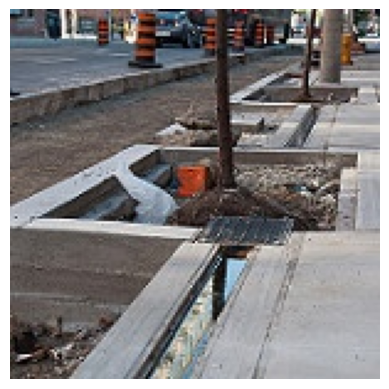

In [6]:
plt.imshow(color_images[0])
plt.axis('off')
plt.show()

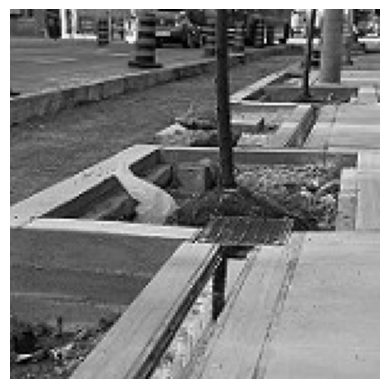

In [7]:
plt.imshow(bw_images[0])
plt.axis('off')
plt.show()

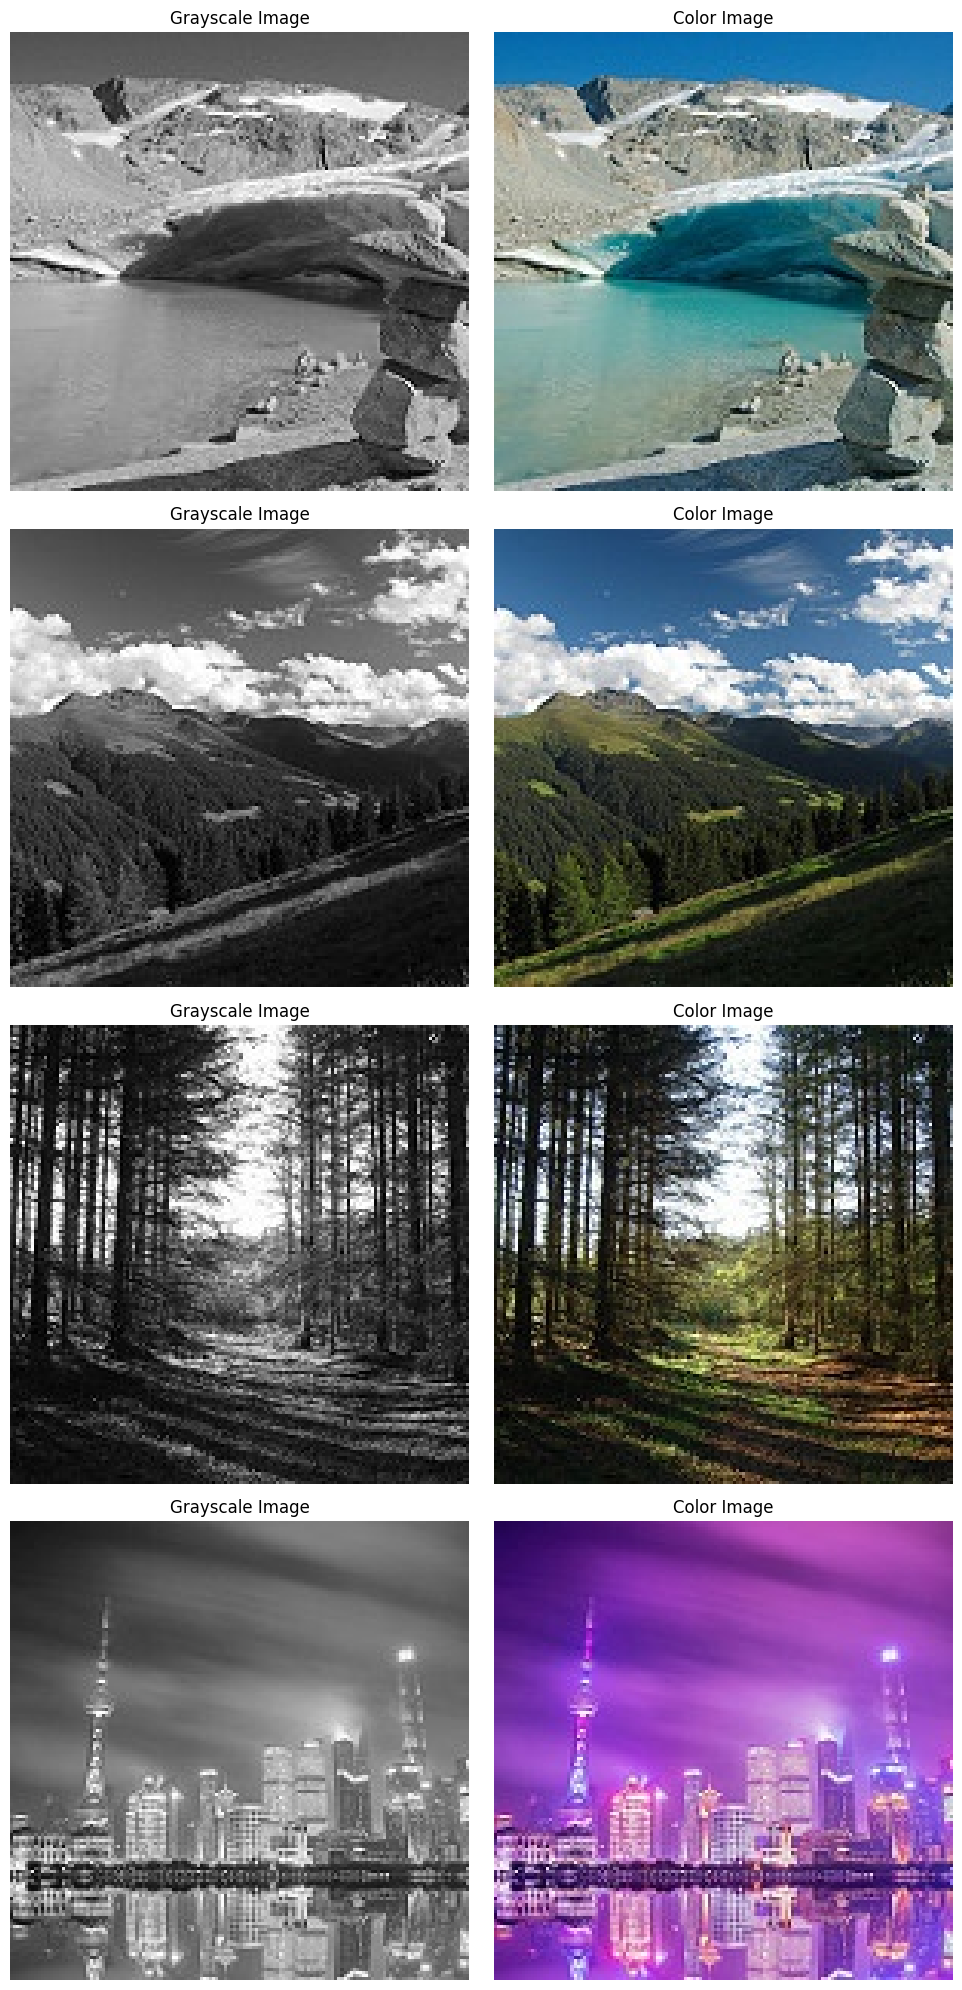

In [8]:
def plot_comparison(grayscale_images, color_images):
    num_images = min(len(grayscale_images), len(color_images))
    fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(10, 5*num_images))

    for i in range(num_images):
        # Plot grayscale image
        axes[i, 0].imshow(grayscale_images[i], cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Grayscale Image')

        # Plot color image
        axes[i, 1].imshow(color_images[i])
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Color Image')

    plt.tight_layout()
    plt.show()

gray=[]
color=[]
for i in range(4):
    number = random.randint(0,7128)
    gray.append(bw_images[number])
    color.append(color_images[number])
plot_comparison(gray, color)


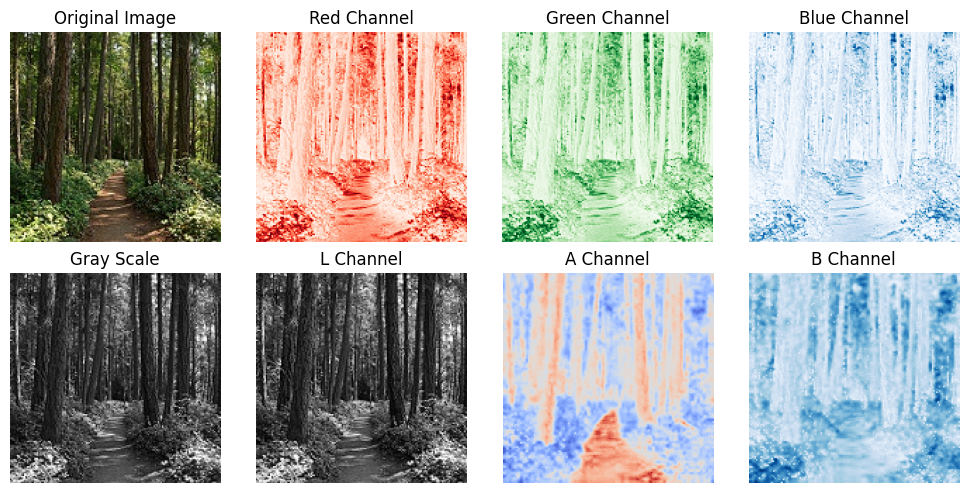

In [9]:
num = random.randint(0,7128)
image = np.array(color_images[num])
image1 = np.array(bw_images[num])
red_channel = image[:, :, 0]
green_channel = image[:, :, 1]
blue_channel = image[:, :, 2]
lab_image = color_images[num].convert('LAB')
l_channel, a_channel, b_channel = lab_image.split()

# Plot Grayscale image
plt.figure(figsize=(10, 5))
plt.subplot(2, 4, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

# Plot RGB channels
plt.subplot(2, 4, 2)
plt.imshow(red_channel, cmap='Reds')
plt.title('Red Channel')
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(green_channel, cmap='Greens')
plt.title('Green Channel')
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(blue_channel, cmap='Blues')
plt.title('Blue Channel')
plt.axis('off')

#plot grayscale image
plt.subplot(2, 4, 5)
plt.imshow(image1)
plt.title('Gray Scale')
plt.axis('off')

#plot LAB channels
plt.subplot(2, 4, 6)
plt.imshow(l_channel, cmap='gray')
plt.title('L Channel')
plt.axis('off')

plt.subplot(2, 4, 7)
plt.imshow(a_channel, cmap='coolwarm')
plt.title('A Channel')
plt.axis('off')

plt.subplot(2, 4, 8)
plt.imshow(b_channel, cmap='Blues')
plt.title('B Channel')
plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
print(type(np.array(color_images[0])))
print(type(bw_images[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [11]:
color = []
for image in color_images:
    image = np.array(image)
    color.append(image)

In [12]:
print(type(color))

<class 'list'>


In [13]:
X_train, X_temp, Y_train, Y_temp = train_test_split(bw_images, color, test_size=0.3, random_state=42)
X_test, X_val, Y_test, Y_val = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

In [14]:
print("Number of elements in X_train_gray:", len(X_train))
print("Number of elements in X_val_gray:", len(X_val))
print("Number of elements in X_test_gray:", len(X_test))
print("Number of elements in X_train_color:", len(Y_train))
print("Number of elements in X_val_color:", len(Y_val))
print("Number of elements in X_test_color:", len(Y_test))

Number of elements in X_train_gray: 4990
Number of elements in X_val_gray: 1070
Number of elements in X_test_gray: 1069
Number of elements in X_train_color: 4990
Number of elements in X_val_color: 1070
Number of elements in X_test_color: 1069


In [15]:
lab_image = color_images[0].convert('LAB')
# print(lab_image[:, :, 1:])
l_channel, a_channel, b_channel = lab_image.split()
print("labspace", lab_image)
print(l_channel)
print(a_channel)
print(b_channel)


labspace <PIL.Image.Image image mode=LAB size=150x150 at 0x795CED793910>
<PIL.Image.Image image mode=L size=150x150 at 0x795CED792BF0>
<PIL.Image.Image image mode=L size=150x150 at 0x795CED792710>
<PIL.Image.Image image mode=L size=150x150 at 0x795CED7939D0>


In [16]:
height = color_images[0].height
width = color_images[0].width
print("Size of the image is: ", height, " x ", width)

Size of the image is:  150  x  150


In [22]:

# Define a custom dataset class
class ColorDataset(Dataset):
    def __init__(self, bw_images, color_images, transform=None):
        self.bw_images = bw_images
        self.color_images = color_images
        self.transform = transform

    def __len__(self):
        return len(self.bw_images)

    def __getitem__(self, idx):
        bw_image = self.bw_images[idx]
        color_image = self.color_images[idx]

        # Extract A and B channels from color image
        ab_channels = color_image[:, :, 1:]

        if self.transform:
            bw_image = self.transform(bw_image)
            ab_channels = self.transform(ab_channels)

        return bw_image, ab_channels

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((150, 150)),
])

# Create datasets and dataloaders
train_dataset = ColorDataset(X_train, Y_train, transform=transform)
val_dataset = ColorDataset(X_val, Y_val, transform=transform)
test_dataset = ColorDataset(X_test, Y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [41]:
def mse_loss(outputs, targets):
    return ((outputs - targets) ** 2).mean()

class ColorizationCNN(nn.Module):
    def __init__(self):
        super(ColorizationCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 2, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ColorizationCNN()
criterion = mse_loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Model is running on device: {device}")

Model is running on device: cuda:0


In [28]:
# Train the model

train_loss = []

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss.append(running_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

# Evaluate the model
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        test_loss += criterion(outputs, targets).item()
print(f"Test Loss: {test_loss / len(test_loader)}")

Epoch 1/20, Loss: 0.008923576541770345
Epoch 2/20, Loss: 0.008755444143062983
Epoch 3/20, Loss: 0.008634275559765788
Epoch 4/20, Loss: 0.008469349382301936
Epoch 5/20, Loss: 0.008342839431208678
Epoch 6/20, Loss: 0.008270398892748814
Epoch 7/20, Loss: 0.008186822189973334
Epoch 8/20, Loss: 0.008095439732409058
Epoch 9/20, Loss: 0.008035153496819429
Epoch 10/20, Loss: 0.00798054146938599
Epoch 11/20, Loss: 0.00792371024353764
Epoch 12/20, Loss: 0.007881649907153005
Epoch 13/20, Loss: 0.007842977877515249
Epoch 14/20, Loss: 0.0078036892406929
Epoch 15/20, Loss: 0.007770970613003159
Epoch 16/20, Loss: 0.0077377369340795735
Epoch 17/20, Loss: 0.007707022428990175
Epoch 18/20, Loss: 0.007672967604146554
Epoch 19/20, Loss: 0.007644143182402238
Epoch 20/20, Loss: 0.007632253954234796
Test Loss: 0.009055062306716162


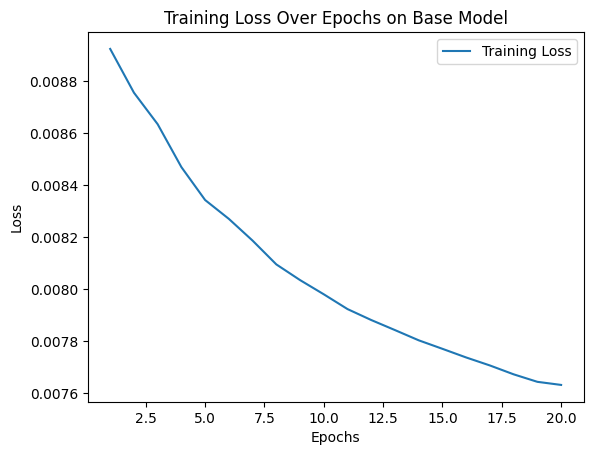

In [36]:
epoc = range(1, len(train_loss) + 1)

plt.plot(epoc, train_loss, label='Training Loss')

plt.title('Training Loss Over Epochs on Base Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()